<a href="https://colab.research.google.com/github/shreddedScientist/MSDS422-Practical-Machine-Learning/blob/main/Bankruptcy_EDA_Chris_Lee%2C_Fulton%2C_MSDS422_Fall_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings
warnings.filterwarnings(action="ignore")

# Preprocessing Libraries

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Machine Learning Libraries
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

df = pd.read_csv('https://raw.githubusercontent.com/shreddedScientist/MSDS422-Practical-Machine-Learning/main/data.csv')


# Data Cleaning and Preprocessing

In [ ]:
#there are no null values
df.isnull().sum().sort_values(ascending=False).head()

 Equity to Liability                 0
 Net Income Flag                     0
 Operating Profit Growth Rate        0
 After-tax Net Profit Growth Rate    0
 Regular Net Profit Growth Rate      0
dtype: int64

In [ ]:
#checking for duplicates, there are none
df.duplicated().sum()

0

In [ ]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

# EDA

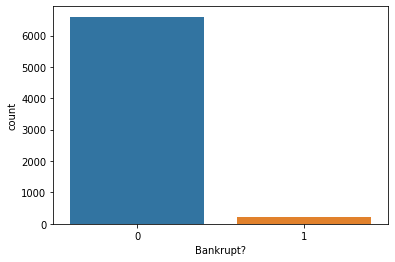

In [ ]:
sns.countplot('Bankrupt?',data=df)

In [ ]:
#There were 220 businesses bankrupt, and 6,599 that were not.
#this means that even if you had assumed all of them were not bankrupt,
#you would still have an accuracy score of 96.77%, therefore anything below
#that would mean your model is not really of use

pd.crosstab(df['Bankrupt?']==0,df['Bankrupt?']==1)

Bankrupt?,False,True
Bankrupt?,,
False,6599,0
True,0,220


In [ ]:
#Create numeric datasets

numeric = df.select_dtypes(include=['number', 'int32','int64','float64']).columns
num_df = df[numeric]


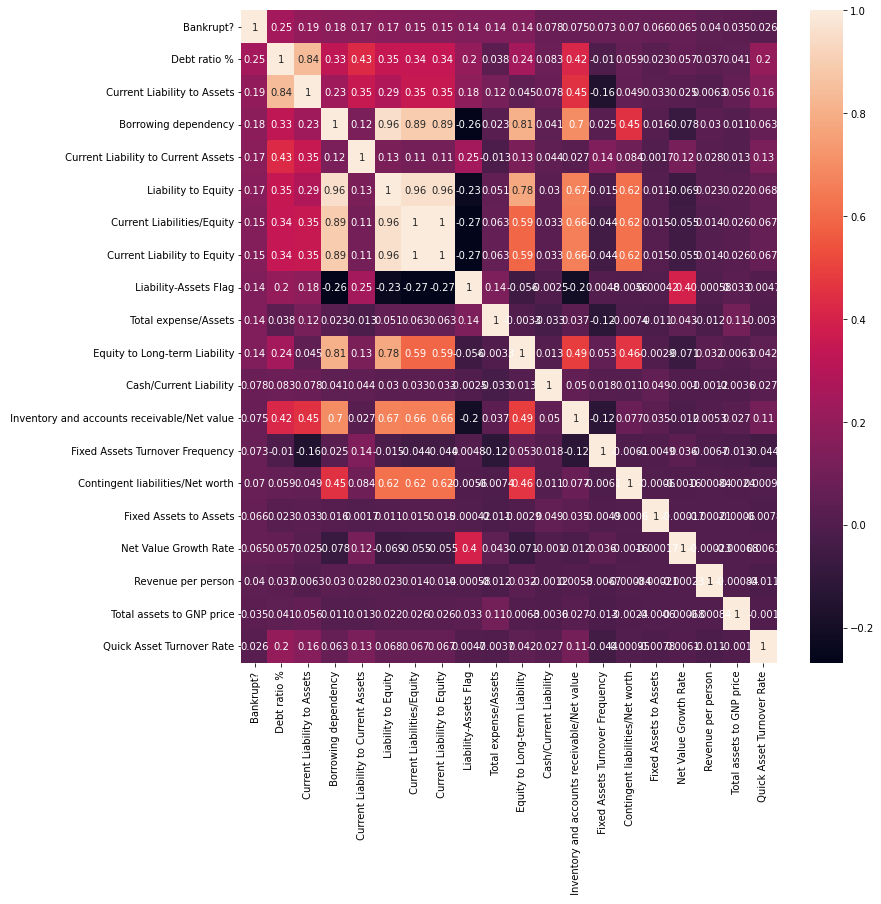

In [ ]:
#correlation heatmap of the strongest correlations
corrmat = num_df.corr()

num_strong_corr = corrmat.nlargest(20, 'Bankrupt?')['Bankrupt?'].index
num_strong_corr

#We create a new correlation heatmap to look at those only
num_corrmat = np.corrcoef(num_df[num_strong_corr].values.T)
fix, ax = plt.subplots(figsize=(12,12))
sns.heatmap(num_corrmat, annot=True, xticklabels = num_strong_corr.values,
            yticklabels = num_strong_corr.values)
plt.show()

In [26]:
#describe just the bankrupt and non-bankrupt companies separately

In [ ]:
df[df['Bankrupt?']==1].describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,220.0,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02,2.200000e+02,220.000000,220.000000,220.000000,2.200000e+02,220.000000,2.200000e+02,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.000000
mean,1.0,0.418503,0.456947,0.461483,0.598670,0.598717,0.998739,0.796590,0.808424,0.302609,0.780799,1.887486e+09,1.605623e+09,0.460681,2.772727e+06,0.031690,0.160416,0.160301,0.160459,0.188818,0.316006,0.027323,0.087354,0.147765,0.022378,0.847087,0.686280,0.686345,0.217121,4.803017e+09,4.240909e+07,0.263358,0.373846,0.007238,4.195455e+07,0.630826,1.577273e+07,0.187047,0.812953,0.011391,...,0.468733,0.047736,0.005021,2.549409e+08,0.144238,0.338991,0.277286,5.842727e+07,0.738046,0.726401,0.342772,5.659091e+07,0.904244,0.002076,0.049858,1.380154e+09,2.640836e+09,0.593864,2.181733e+09,0.671555,3.781818e+07,0.738046,0.342772,0.130512,0.631452,0.454778,0.556412,0.311426,0.060443,0.027273,0.738083,9.100000e+07,0.623541,0.598669,0.826008,0.293578,0.028443,0.564959,1.0,0.024832
std,0.0,0.081068,0.107674,0.091825,0.014595,0.014583,0.000709,0.003177,0.004174,0.005099,0.003120,3.257616e+09,

In [ ]:
df[df['Bankrupt?']==0].describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6599.0,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6.599000e+03,6.599000e+03,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6.599000e+03,6.599000e+03,6599.000000,6599.000000,6.599000e+03,6.599000e+03,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,...,6599.000000,6599.000000,6.599000e+03,6.599000e+03,6599.000000,6599.000000,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6.599000e+03,6.599000e+03,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6.599000e+03,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.000000,6599.0,6599.000000
mean,0.0,0.508069,0.562015,0.556659,0.608257,0.608237,0.998756,0.797210,0.809106,0.303657,0.781401,1.998943e+09,1.961923e+09,0.467656,1.690392e+07,0.117778,0.191669,0.191644,0.191680,0.230146,0.323731,1.372935e+06,0.109815,0.185581,0.022409,0.848010,0.689242,0.689244,0.217656,5.531603e+09,2.045765e+05,0.264277,0.379871,4.167298e+05,7.257160e+06,0.630997,4.037733e+06,0.110714,0.889286,0.008696,...,0.524058,0.126640,3.712684e+06,2.989953e+07,0.088887,0.354323,0.277399,5.571944e+07,0.762384,0.736130,0.331031,5.407900e+07,0.935749,0.002565,0.028495,1.189712e+09,2.147829e+09,0.594011,2.481653e+09,0.671530,0.246886,0.762384,0.331031,0.115149,0.650340,0.462085,0.594649,0.315721,0.030542,0.000303,0.810083,1.621670e+07,0.623927,0.608256,0.840882,0.279925,0.027511,0.565371,1.0,0.048337
std,0.0,0.057694,0.060898,0.057864,0

In [ ]:
def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    feat_iqr = q75 - q25
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off

    outliers = [x for x in feature if x < feat_lower or x > feat_upper]

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)

    return dataset

for col in df:
    new_df = outliers_removal(df[col],str(col),df)

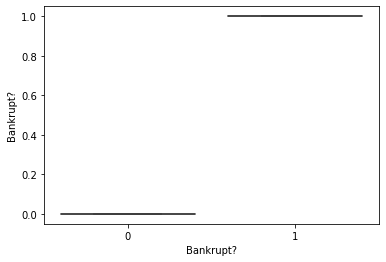

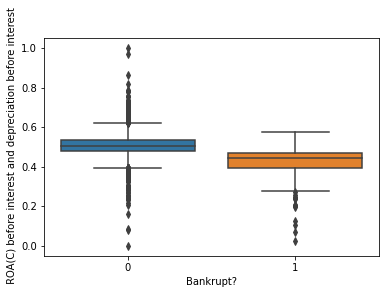

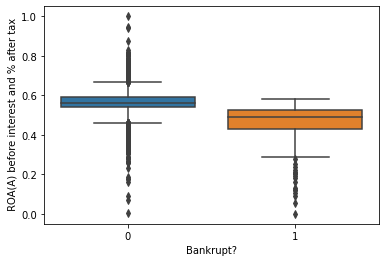

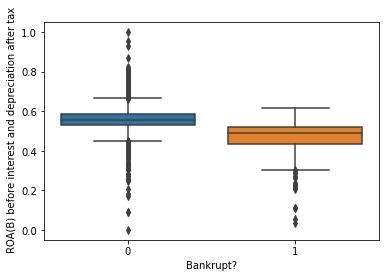

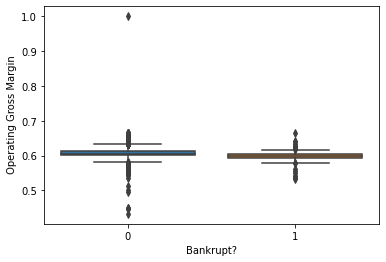

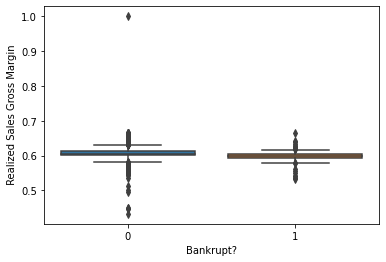

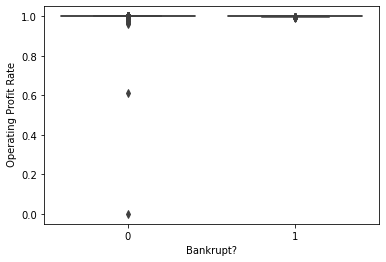

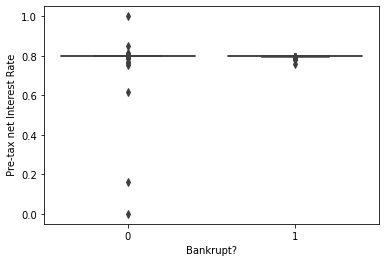

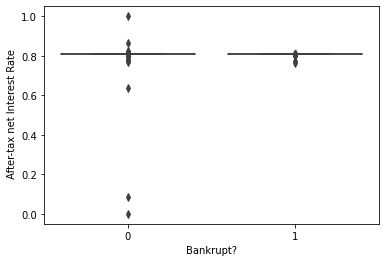

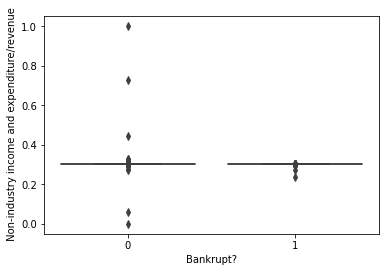

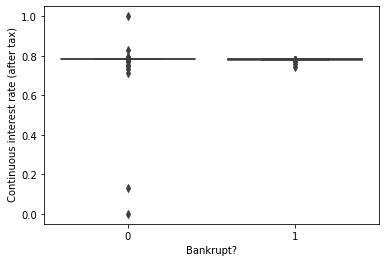

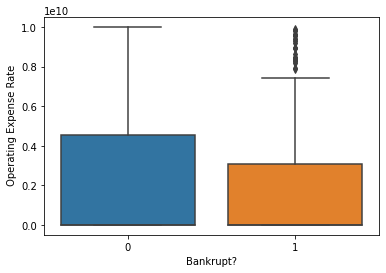

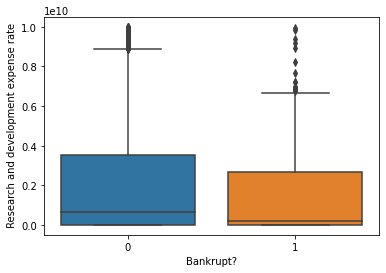

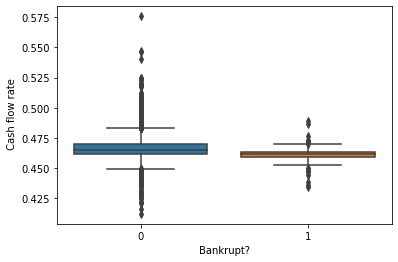

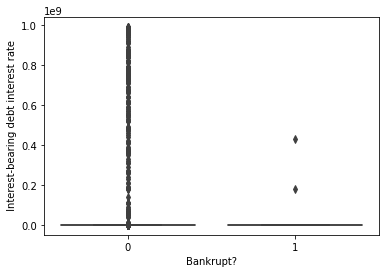

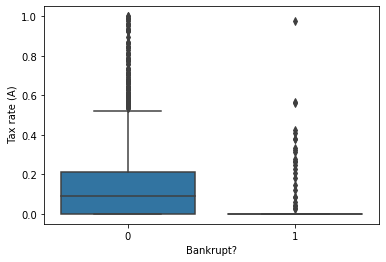

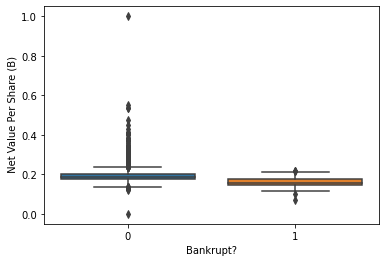

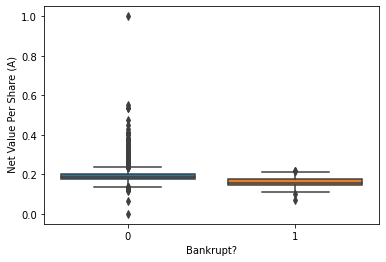

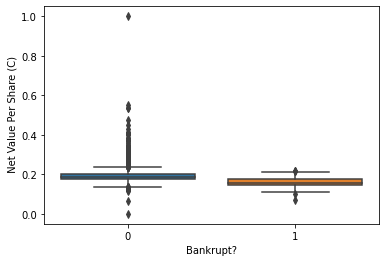

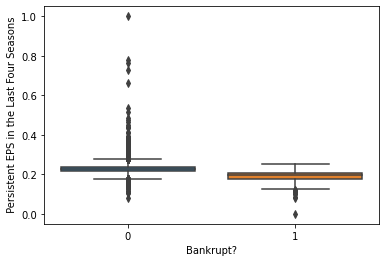

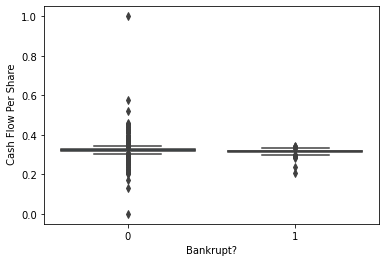

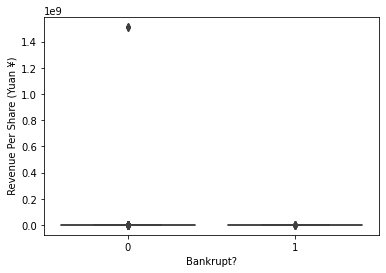

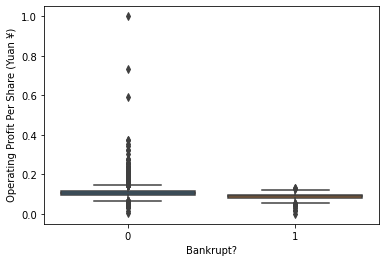

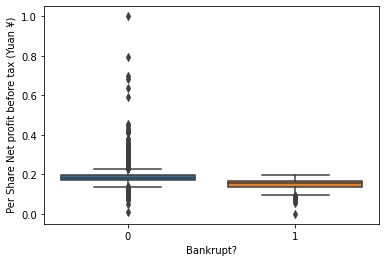

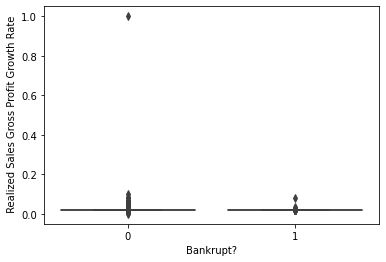

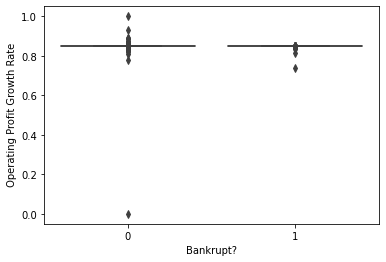

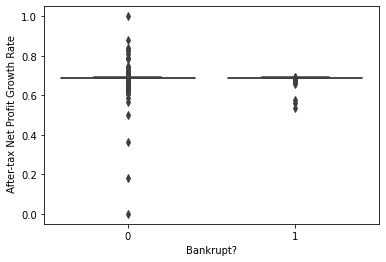

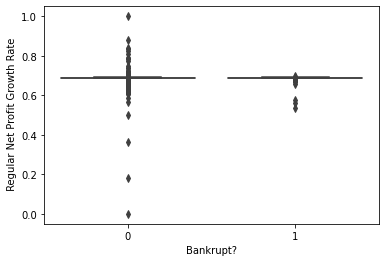

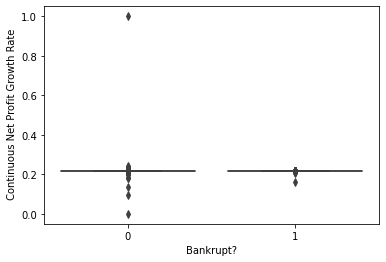

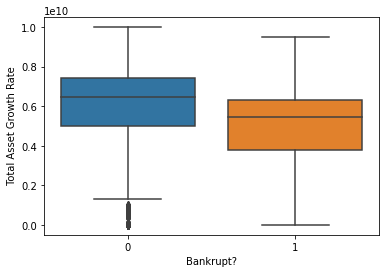

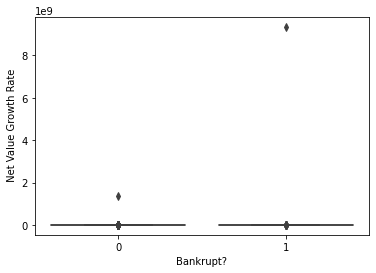

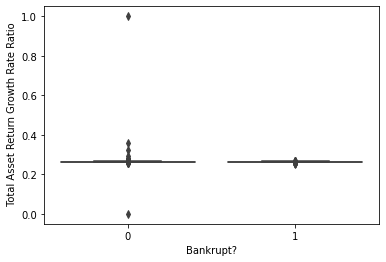

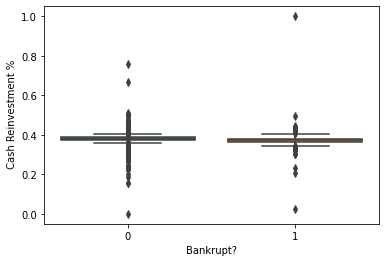

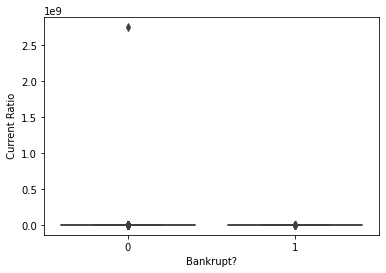

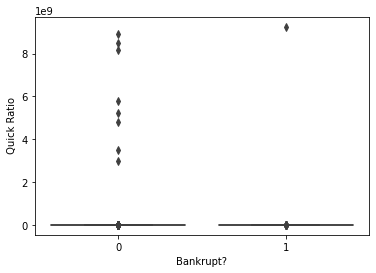

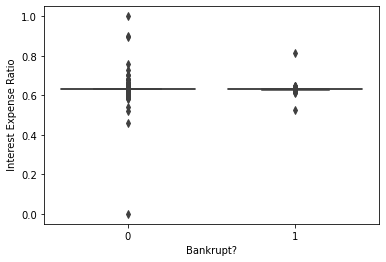

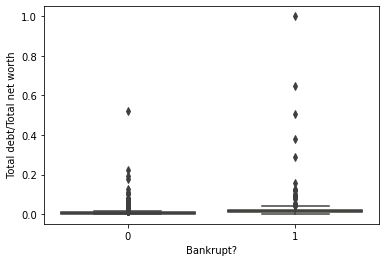

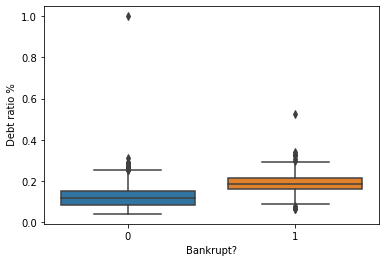

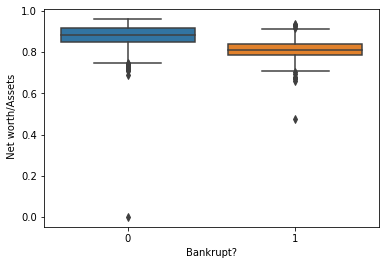

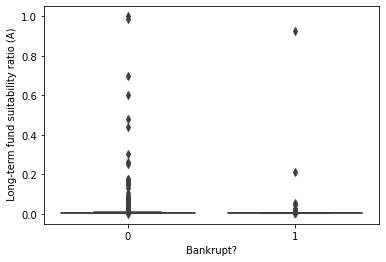

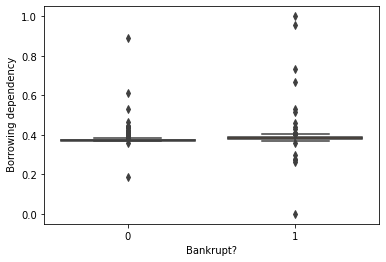

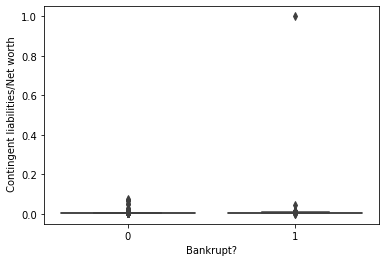

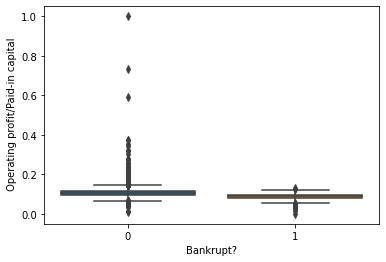

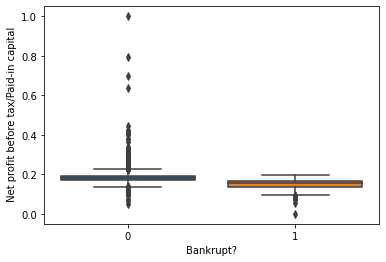

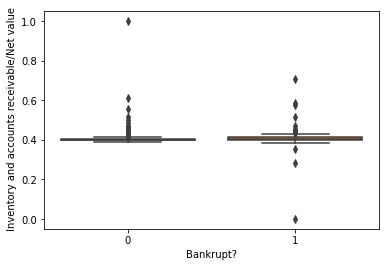

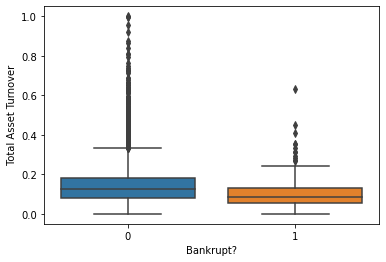

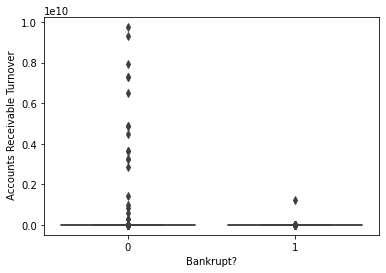

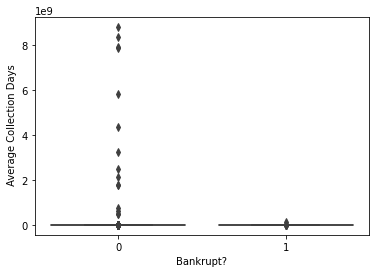

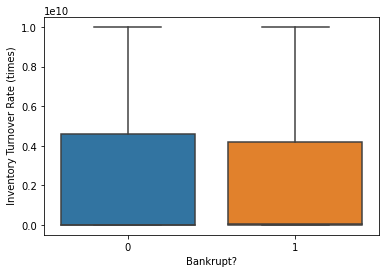

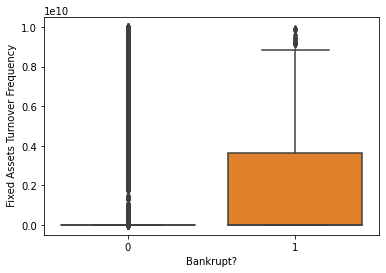

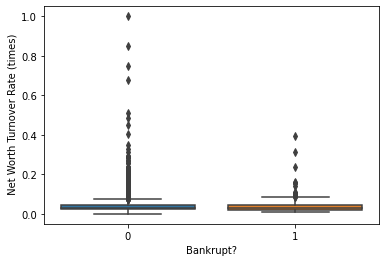

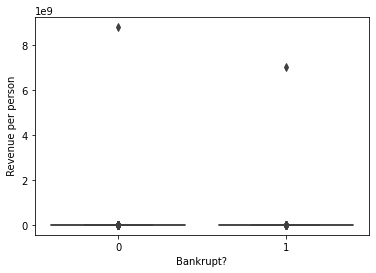

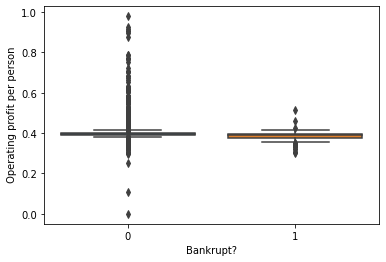

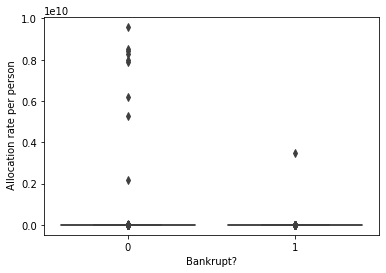

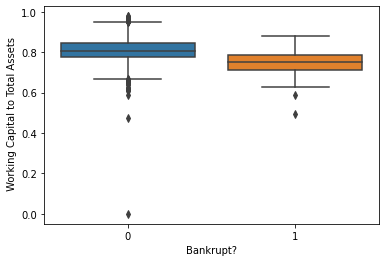

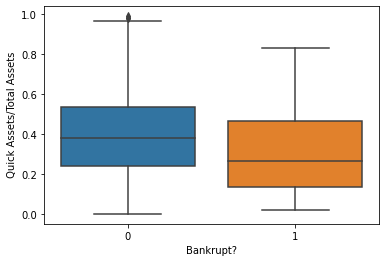

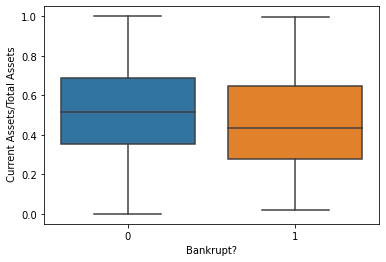

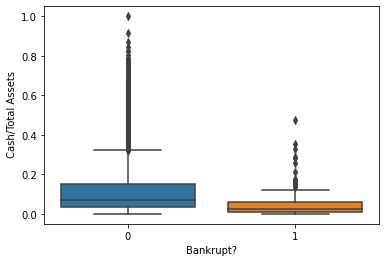

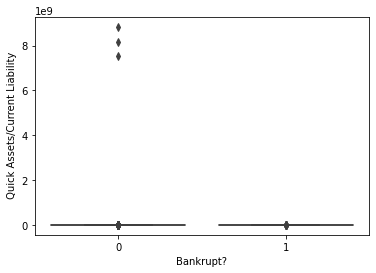

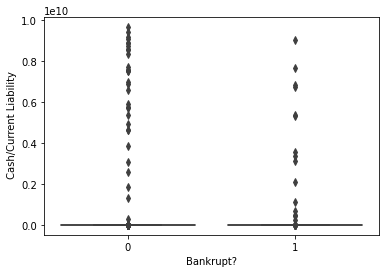

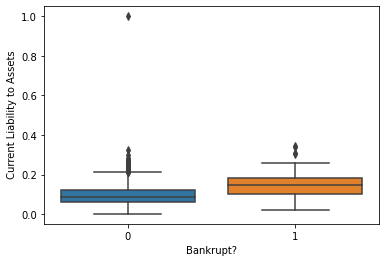

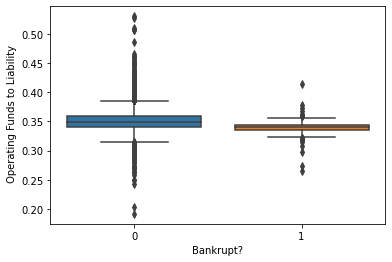

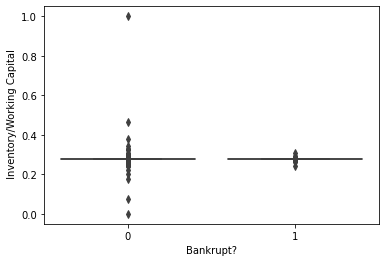

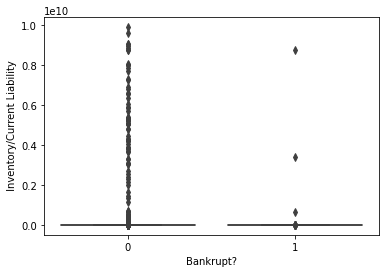

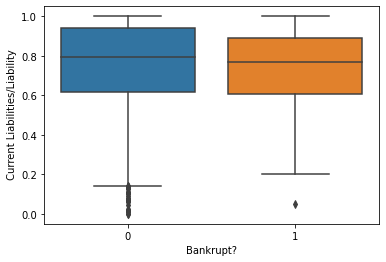

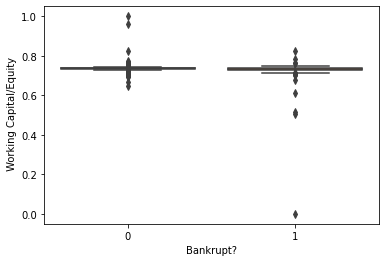

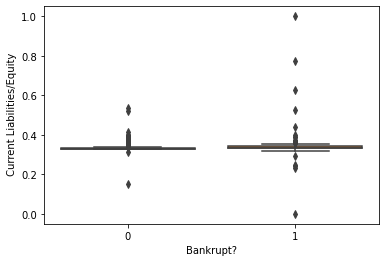

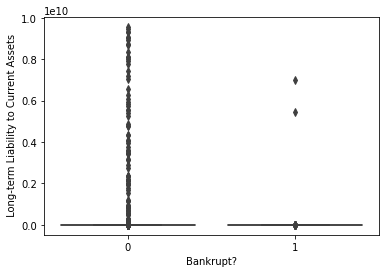

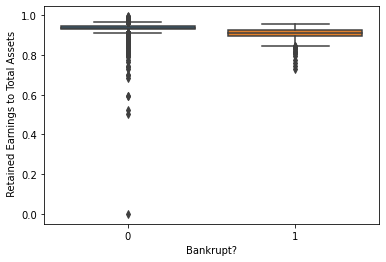

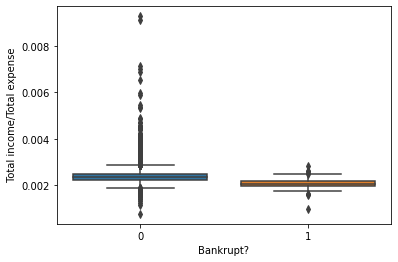

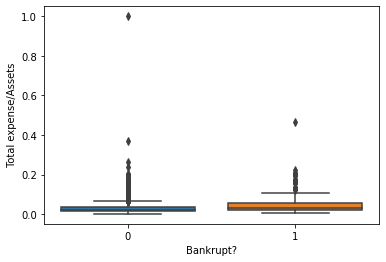

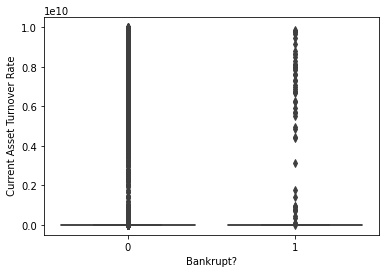

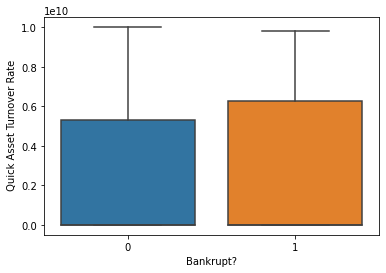

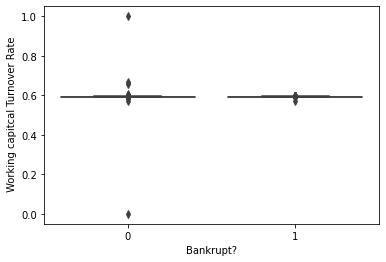

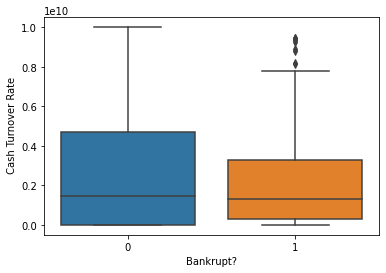

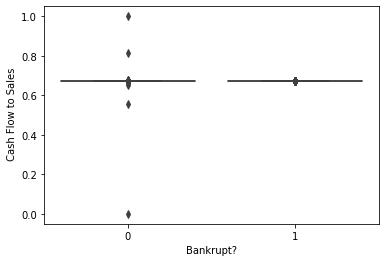

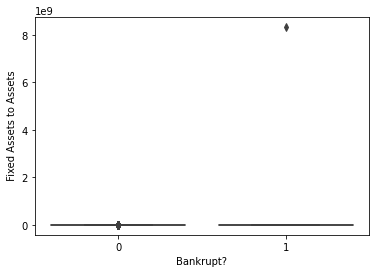

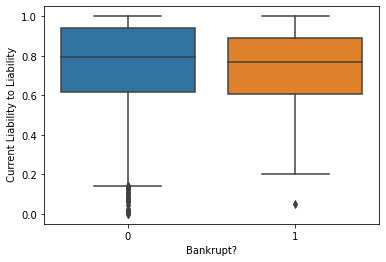

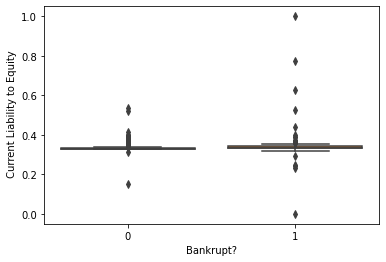

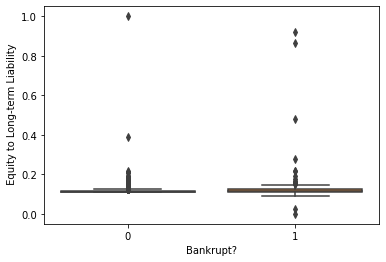

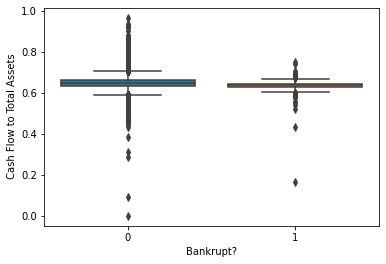

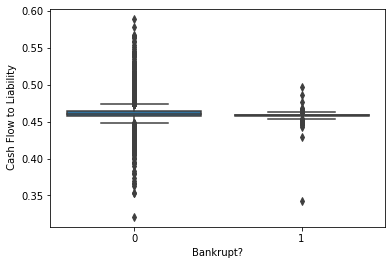

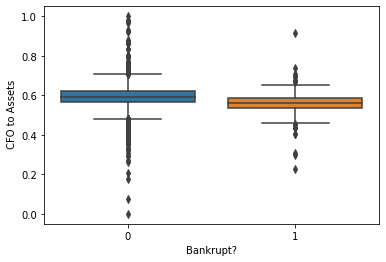

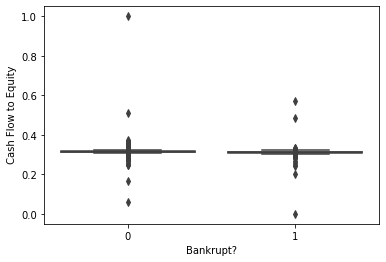

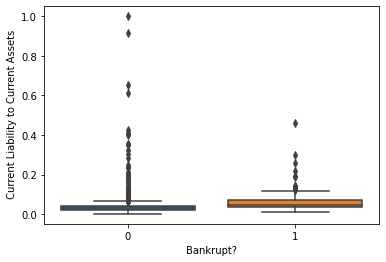

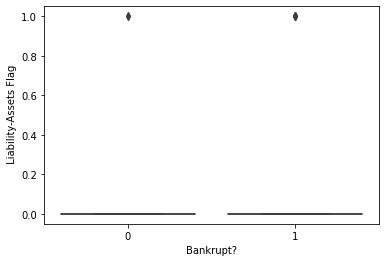

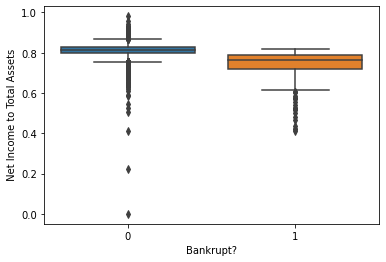

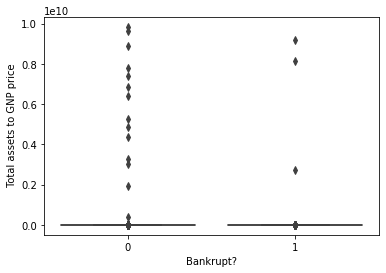

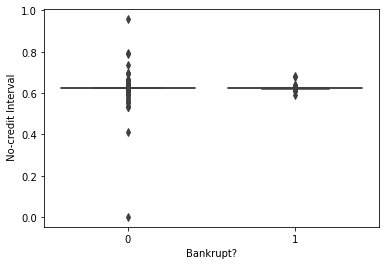

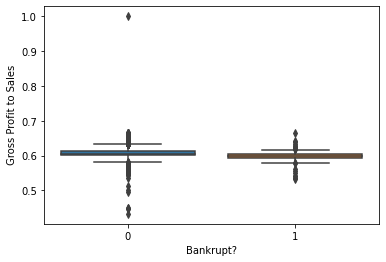

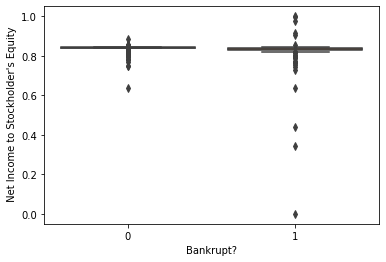

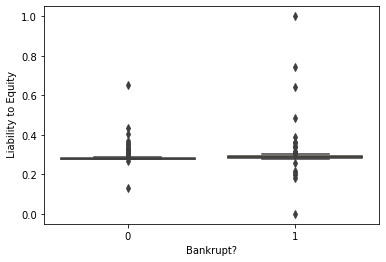

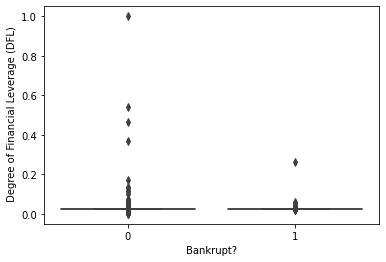

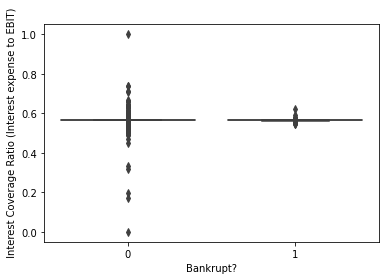

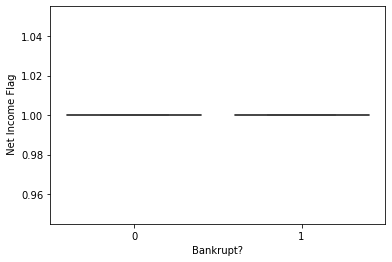

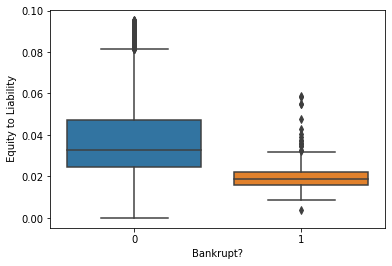

In [ ]:
#plotting the outlier removed dataset

for column in numeric:
    fig, ax = plt.subplots()
    sns.boxplot(y=column, data = new_df, x = 'Bankrupt?')

plt.show()

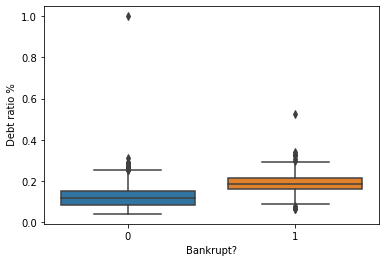

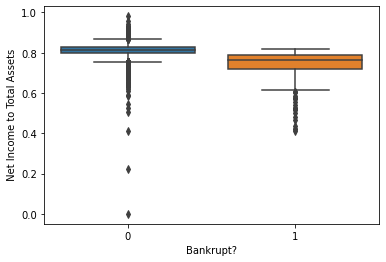

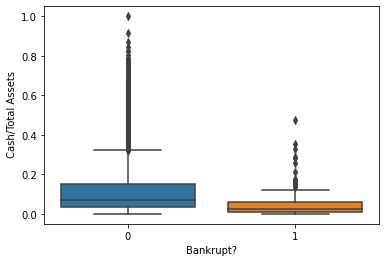

In [ ]:
# Plotting possible strong predictors

sns.boxplot(x='Bankrupt?', y=" Debt ratio %", data=new_df)
plt.show()
sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=new_df)
plt.show()
sns.boxplot(x='Bankrupt?', y=" Cash/Total Assets", data=new_df)
plt.show()

In [25]:
# Dividing Data and Labels

labels = new_df['Bankrupt?']
new_df = new_df.drop(['Bankrupt?'], axis = 1)

KeyError: ignored

In [ ]:
def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

data_norm = log_trans(new_df)

In [ ]:
# Splitting Train and Test Data

X_raw,X_test,y_raw,y_test  = train_test_split(data_norm,
                                              labels,
                                              test_size=0.1,
                                              stratify = labels,
                                              random_state = 42)

# Logistic Regression

In [24]:
# Stratified Cross Validation Splitting

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "Test:", test_index)
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

# Check the Distribution of the labels


# Turn into an array
X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))

Train: [1005 1097 1131 ... 5640 5641 5642] Test: [   0    1    2 ... 1128 1129 1130]
Train: [   0    1    2 ... 5640 5641 5642] Test: [1005 1097 1131 ... 2256 2257 2258]
Train: [   0    1    2 ... 5640 5641 5642] Test: [2224 2259 2260 ... 3384 3385 3438]
Train: [   0    1    2 ... 5640 5641 5642] Test: [3386 3387 3388 ... 4512 4513 4514]
Train: [   0    1    2 ... 4512 4513 4514] Test: [4515 4516 4517 ... 5640 5641 5642]
------------------------------------------------------------------------------------
Label Distributions: 

[0.96522702 0.03477298]
[0.96542553 0.03457447]


In [ ]:
# List to append the score and then find the average

accuracy_lst_reg = []
precision_lst_reg = []
recall_lst_reg = []
f1_lst_reg = []
auc_lst_reg = []

log_reg_sm = LogisticRegression()
#log_reg_params = {}
log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model_reg = pipeline_reg.fit(X_train_sm[train], y_train_sm[train])
    best_est_reg = rand_log_reg.best_estimator_
    prediction_reg = best_est_reg.predict(X_train_sm[val])
    
    accuracy_lst_reg.append(pipeline_reg.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_reg.append(precision_score(y_train_sm[val], prediction_reg))
    recall_lst_reg.append(recall_score(y_train_sm[val], prediction_reg))
    f1_lst_reg.append(f1_score(y_train_sm[val], prediction_reg))
    auc_lst_reg.append(roc_auc_score(y_train_sm[val], prediction_reg))


print('---' * 45)
print('')
print('Logistic Regression (SMOTE) results:\n')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_reg)))
print("precision: {}".format(np.mean(precision_lst_reg)))
print("recall: {}".format(np.mean(recall_lst_reg)))
print("f1: {}".format(np.mean(f1_lst_reg)))
print('')
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

Logistic Regression (SMOTE) results:

accuracy: 0.8761904761904761
precision: 0.1922364572730181
recall: 0.7637096774193548
f1: 0.3057068195003593

---------------------------------------------------------------------------------------------------------------------------------------


In [22]:
# Printing the classification report

label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_val_sm)
print(classification_report(y_val_sm, pred_reg_sm, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.90      0.94      1089
Fin.Unstable       0.20      0.67      0.31        39

    accuracy                           0.90      1128
   macro avg       0.59      0.79      0.62      1128
weighted avg       0.96      0.90      0.92      1128

